In [73]:
import aim_modules as am
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [74]:
# collect all of the TI information
runs = ["run01","run02","run03","run04","run05"]
ti_home = "/Users/ChrisM/Documents/workspace/TI/"
times = ["100ps","250ps","500ps","1ns","5ns","10ns"]
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
results = {}
for i in times:
    root = ti_home+i
    results[i] = am.import_pickle(root, runs, i)

In [75]:
# collect AIM results
cubic_states = {}
trapz_states = {}
aim_counts = {}
aim_averages = {}
num_lams = 21

aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}

df_allk = {}

for j in times:
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_counts[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    df_allk[j] = {}
    aim_dgdcoulavg = np.zeros(num_lams)
    aim_dgdvdwavg = np.zeros(num_lams)
    avg = np.zeros(num_lams-1)
    for i in runs:
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = "/Users/ChrisM/Documents/workspace/AIM/{0}/{0}{1}.out".format(j, i)

        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas = am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}
            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

    
        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(runs)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(runs)
        
    df_allk[j]['AIM_VDW'] = aim_dgdvdwavg
        
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)
    df_allk[j]['Coul_Lambdas'] = coulLambdas
    df_allk[j]['VdW_Lambdas'] = vdwLambdas

    aim_averages[j] = avg
    

In [76]:
# collect TI results
cubic_states = {}
trapz_states = {}
ti_dhdl_states = {}
ti_dgdcoul_averages = {}
ti_dgdvdw_averages = {}
ti_averages = {}
num_lams = len(coulLambdas)

ti_dgdcoul = {}
ti_dgdvdw = {}

for j in times:
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    ti_dhdl_states[j] = {}
    ti_dgdcoul[j] = {}
    ti_dgdvdw[j] = {}
    ti_dgdcoulavg = np.zeros(num_lams)
    ti_dgdvdwavg = np.zeros(num_lams)
    avg = np.zeros(num_lams-1)
    for i in runs:
        file_in = "/Users/ChrisM/Documents/workspace/TI/{0}/{1}.out".format(j, i)
        ti, ti_cubic, trapz, cubic, dhdl, dgdcoul, dgdvdw = am.quad_TI(file_in, ti_names, coulLambdas, vdwLambdas)
        totals.append(ti)
        cubics.append(ti_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        ti_dhdl_states[j][i] = dhdl
        ti_dgdcoul[j][i] = dgdcoul
        ti_dgdvdw[j][i] = dgdvdw

        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            ti_dgdcoulavg[k] += ti_dgdcoul[j][i][k]/len(runs)
            ti_dgdvdwavg[k] += ti_dgdvdw[j][i][k]/len(runs)
            
    df_allk[j]['FIXED_VDW'] = ti_dgdvdwavg
    df_allk[j]['Coul_Lambdas'] = coulLambdas
    df_allk[j]['VdW_Lambdas'] = vdwLambdas
    ti_averages[j] = avg


In [77]:
df = pd.DataFrame()
for i in times:
    twentyone_lambdas = pd.DataFrame.from_dict(df_allk[i])
    twentyone_lambdas['time'] = i
    df = pd.concat([df, twentyone_lambdas], ignore_index=True)

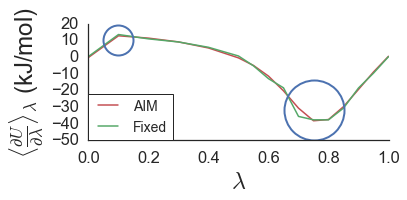

In [78]:
fig = plt.figure(figsize=(6,3))
times = ['100ps']

for j in times:
    twentyone_lambdas = df[df['time'] == j]

    sns.lineplot(x="VdW_Lambdas", y='AIM_VDW', label="AIM", color='r', data=twentyone_lambdas);
    sns.lineplot(x="VdW_Lambdas", y="FIXED_VDW", label="Fixed", color='g', data=twentyone_lambdas);

# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)

plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
plt.xlabel(r'$\lambda$', fontsize = 24);
plt.xlim(0.0,1.0);
plt.ylim(-50, 20);
#plt.title("Ethanol 21 lambdas at 5ns per lambda", fontsize=24);

point = [0.1,10]
circle_rad = 15  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

point = [0.75,-32]
circle_rad = 30  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1);
plt.tick_params(axis=u'both', which=u'both',length=0)
sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")
plt.tight_layout()
plt.savefig("figures/Ethanol_21_lambdas_at_{0}_per_lambda.eps".format(j), dpi=600)
plt.show()

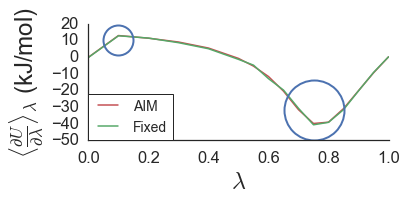

In [79]:
fig = plt.figure(figsize=(6,3))
times = ['500ps']

for j in times:
    twentyone_lambdas = df[df['time'] == j]

    sns.lineplot(x="VdW_Lambdas", y='AIM_VDW', label="AIM", color='r', data=twentyone_lambdas);
    sns.lineplot(x="VdW_Lambdas", y="FIXED_VDW", label="Fixed", color='g', data=twentyone_lambdas);

# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)

plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
plt.xlabel(r'$\lambda$', fontsize = 24);
plt.xlim(0.0,1.0);
plt.ylim(-50, 20);
#plt.title("Ethanol 21 lambdas at 5ns per lambda", fontsize=24);

point = [0.1,10]
circle_rad = 15  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

point = [0.75,-32]
circle_rad = 30  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1);
plt.tick_params(axis=u'both', which=u'both',length=0)
sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")
plt.tight_layout()
plt.savefig("figures/Ethanol_21_lambdas_at_{0}_per_lambda.eps".format(j), dpi=600)
plt.show()

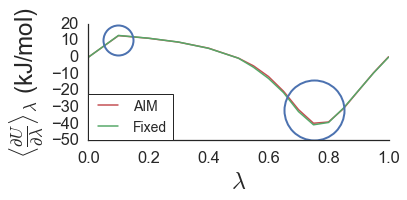

In [80]:
fig = plt.figure(figsize=(6,3))
times = ['1ns']

for j in times:
    twentyone_lambdas = df[df['time'] == j]

    sns.lineplot(x="VdW_Lambdas", y='AIM_VDW', label="AIM", color='r', data=twentyone_lambdas);
    sns.lineplot(x="VdW_Lambdas", y="FIXED_VDW", label="Fixed", color='g', data=twentyone_lambdas);

# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)

plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
plt.xlabel(r'$\lambda$', fontsize = 24);
plt.xlim(0.0,1.0);
plt.ylim(-50, 20);
#plt.title("Ethanol 21 lambdas at 5ns per lambda", fontsize=24);

point = [0.1,10]
circle_rad = 15  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

point = [0.75,-32]
circle_rad = 30  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1);
plt.tick_params(axis=u'both', which=u'both',length=0)
sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")
plt.tight_layout()
plt.savefig("figures/Ethanol_21_lambdas_at_{0}_per_lambda.eps".format(j), dpi=600)
plt.show()

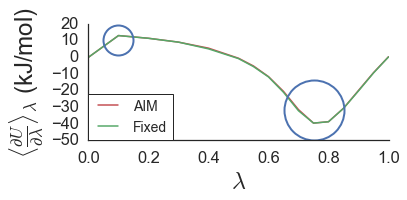

In [81]:
fig = plt.figure(figsize=(6,3))
times = ['5ns']

for j in times:
    twentyone_lambdas = df[df['time'] == j]

    sns.lineplot(x="VdW_Lambdas", y='AIM_VDW', label="AIM", color='r', data=twentyone_lambdas);
    sns.lineplot(x="VdW_Lambdas", y="FIXED_VDW", label="Fixed", color='g', data=twentyone_lambdas);

# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)

plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
plt.xlabel(r'$\lambda$', fontsize = 24);
plt.xlim(0.0,1.0);
plt.ylim(-50, 20);
#plt.title("Ethanol 21 lambdas at 5ns per lambda", fontsize=24);

point = [0.1,10]
circle_rad = 15  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

point = [0.75,-32]
circle_rad = 30  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

plt.legend(loc=0, borderaxespad=0., fontsize=14, ncol=1);
plt.tick_params(axis=u'both', which=u'both',length=0)
sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")
plt.tight_layout()
plt.savefig("figures/Ethanol_21_lambdas_at_{0}_per_lambda.eps".format(j), dpi=600)
plt.show()

In [82]:
time = {'100ps':0.1,'250ps':0.25,'500ps':0.5,'1ns':1,'5ns':5,'10ns':10}
df['timens'] = 0
for i in time.keys():
    df['timens'][df['time'] == i] = time[i]

/Users/ChrisM/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [83]:
keys = ['BAR', 'MBAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']
# Plot the results using error bars for each lambda window
df = pd.DataFrame()
for i in keys:
    ddf = pd.DataFrame()
    ddf['250 ps'] = np.array(results['250ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['500 ps'] = np.array(results['500ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['1 ns'] = np.array(results['1ns'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['5 ns'] = np.array(results['5ns'][i].apply(np.vectorize(am.convert_to_kcal)))

    ddf['key'] = i
    df = pd.concat([df,ddf])

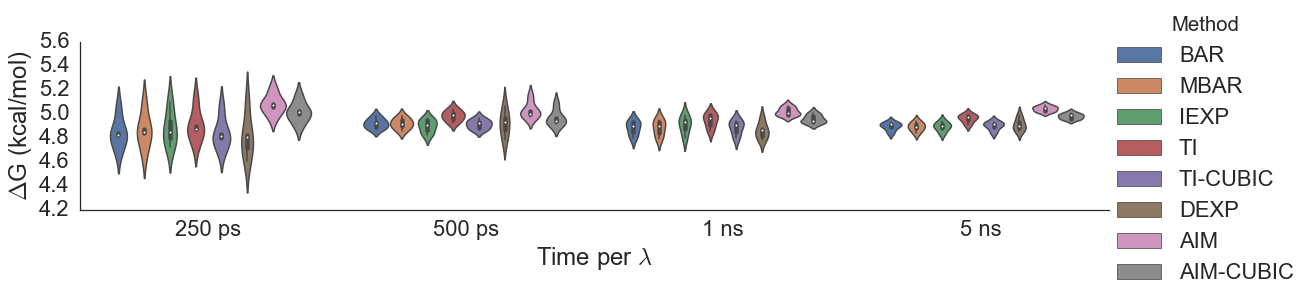

In [85]:
melted_df = pd.melt(df,
                   id_vars = 'key',
                   value_vars = ['250 ps','500 ps','1 ns', '5 ns'],
                   var_name = 'Time',
                   value_name = 'DeltaG(kcal/mol)')

melted_df.columns = ['Method', 'Time','DeltaG(kcal/mol)']


g = sns.catplot(x="Time",
            y="DeltaG(kcal/mol)",
            hue="Method"
            ,data=melted_df,
            kind="violin",
            height=4,
            aspect=4,
            legend_out=True)
plt.ylabel("$\Delta$G (kcal/mol)", fontsize = 24)
plt.xlabel("Time per $\lambda$", fontsize = 24)

fig.set_size_inches(6, 3)

sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=2.0)
sns.set_style("white")
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig("figures/Ethanol_21_lambdas_overtime_violinplot.eps", dpi=600)

In [86]:
keys = ['BAR', 'IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM', 'AIM-CUBIC']
# Plot the results using error bars for each lambda window
df = pd.DataFrame()
for i in keys:
    ddf = pd.DataFrame()
    ddf['100 ps'] = np.array(results['100ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['250 ps'] = np.array(results['250ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['500 ps'] = np.array(results['500ps'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['1 ns'] = np.array(results['1ns'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['5 ns'] = np.array(results['5ns'][i].apply(np.vectorize(am.convert_to_kcal)))
    ddf['10 ns'] = np.array(results['10ns'][i].apply(np.vectorize(am.convert_to_kcal)))


    ddf['key'] = i
    df = pd.concat([df,ddf])

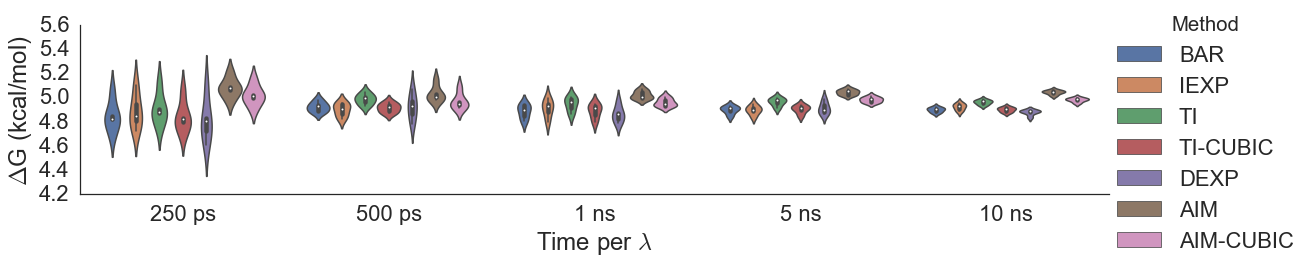

In [89]:
melted_df = pd.melt(df,
                   id_vars = 'key',
                   value_vars = ['250 ps','500 ps', '1 ns','5 ns', '10 ns'],
                   var_name = 'Time',
                   value_name = 'DeltaG(kcal/mol)')

melted_df.columns = ['Method', 'Time','DeltaG(kcal/mol)']

g = sns.catplot(x="Time",
            y="DeltaG(kcal/mol)",
            hue="Method"
            ,data=melted_df,
            kind="violin",
            height=4,
            aspect=4,
            legend_out=True)

plt.ylabel("$\Delta$G (kcal/mol)", fontsize = 24)
plt.xlabel("Time per $\lambda$", fontsize = 24)
sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=2.0)
sns.set_style("white")
plt.tick_params(axis=u'both', which=u'both',length=0)
#plt.savefig("Ethanol_21_lambdas_overtime_violinplot.eps", dpi=600)

In [90]:
# collect all of the TI information
runs = ["run01","run02","run03","run05"]
ti_home = "/Users/ChrisM/Documents/workspace/TI/33ls/"
times = ["100ps"]
names = ["N","CoulL","VdwL","Count","G","dG","AIMCount","dGCoulL","dGVdwL"]
ti_names = ["dGCoulL","dGVdwL"]

# create a dictionary to hold our results
# each result is a dataframe
# these results aren't comparable because they are for a different setup but we use
# this to init our dictionary
results = {}
for i in times:
    root = ti_home
    results[i] = am.import_pickle(root, runs, "results")

In [91]:
# collect AIM results
cubic_states = {}
trapz_states = {}
aim_counts = {}
aim_averages = {}
num_lams = 33

aim_dhdl_states = {}
aim_dgdcoul = {}
aim_dgdvdw = {}
aim_dhdl_states = {}
aim_dgdcoul_averages = {}
aim_dgdvdw_averages = {}

df_allk = {}

for j in times:
    files = ["33ls/aim{0}33ls0{1}.out".format(j,i) for i in range(1,5)]
    totals = []
    cubics = []
    cubic_states[j] = {}
    trapz_states[j] = {}
    aim_counts[j] = {}
    aim_dhdl_states[j] = {}
    aim_dgdcoul[j] = {}
    aim_dgdvdw[j] = {}
    df_allk[j] = {}
    aim_dgdcoulavg = np.zeros(num_lams)
    aim_dgdvdwavg = np.zeros(num_lams)
    avg = np.zeros(num_lams-1)
    for i in files:
        cubic_states[j][i] = []
        trapz_states[j][i] = []
        aim_dhdl_states[j][i] = []
        file_in = "/Users/ChrisM/Documents/workspace/AIM/{0}".format(i)
        aim, aim_cubic, counts, trapz, cubic, dhdl, dgdcoul, dgdvdw, coulLambdas, vdwLambdas = am.quad_AIM(file_in, names)
        totals.append(aim)
        cubics.append(aim_cubic)
        trapz_states[j][i] = trapz
        cubic_states[j][i] = cubic
        aim_dhdl_states[j][i] = dhdl
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw
        
        aim_averages[j] = {}
            
        aim_dgdcoul[j][i] = dgdcoul
        aim_dgdvdw[j][i] = dgdvdw

    
        for k in range(num_lams-1):
            avg[k] += trapz_states[j][i][k]/len(runs)
        for k in range(num_lams):
            aim_dgdcoulavg[k] += aim_dgdcoul[j][i][k]/len(runs)
            aim_dgdvdwavg[k] += aim_dgdvdw[j][i][k]/len(runs)
        
    df_allk[j]['AIM_VDW'] = aim_dgdvdwavg
    results[j]['AIM'] = np.array(totals)
    results[j]['AIM-CUBIC'] = np.array(cubics)
    df_allk[j]['Coul_Lambdas'] = coulLambdas
    df_allk[j]['VdW_Lambdas'] = vdwLambdas

    aim_averages[j] = avg
    


In [92]:
df = pd.DataFrame()
for i in times:
    thirtythree_lambdas = pd.DataFrame.from_dict(df_allk[i])
    thirtythree_lambdas['time'] = i
    df = pd.concat([df, thirtythree_lambdas], ignore_index=True)

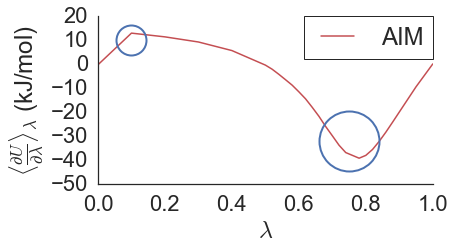

In [61]:
fig = plt.figure(figsize=(6,3))

for j in times:
    thirtythree_lambdas = df[df['time'] == j]

    sns.lineplot(x="VdW_Lambdas", y='AIM_VDW', label="AIM".format(j), color='r', data=thirtythree_lambdas);
    #sns.lineplot(x="VdW_Lambdas", y="FIXED_VDW", label="Fixed".format(j), color='g', data=thirtythree_lambdas);

# Remove the "spines" (the lines surrounding the subplot)    
sns.despine(left=False)
    
plt.ylabel(r'$\langle\frac{\partial U}{\partial \lambda}\rangle$$_{\lambda}$ (kJ/mol)', fontsize = 24);
plt.xlabel(r'$\lambda$', fontsize = 24);
plt.xlim(0.0,1.0);
plt.ylim(-50, 20);

point = [0.1,10]
circle_rad = 15  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)

point = [0.75,-32]
circle_rad = 30  # This is the radius, in points
plt.plot(point[0], point[1], 'o',
        ms=circle_rad * 2, mec='b', mfc='none', mew=2)
plt.legend(loc=0, borderaxespad=0., fontsize=24, ncol=1);
#fig.set_size_inches(6, 3)
plt.tick_params(axis=u'both', which=u'both',length=0)
sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")
plt.savefig("figures/Ethanol_33_lambdas_at_100ps_per_lambda.eps", dpi=600)

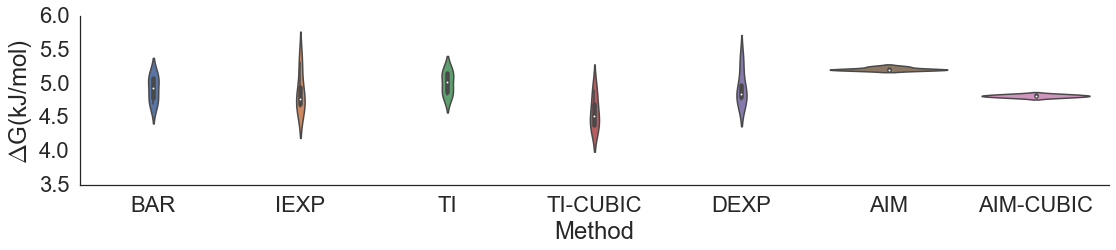

In [93]:
for i in times:
    thirtythree_lambdas = results[i].apply(np.vectorize(am.convert_to_kcal))
    thirtythree_lambdas['Number of Lambdas'] = 31
    columns = ['BAR','IEXP', 'TI', 'TI-CUBIC', 'DEXP', 'AIM',
           'AIM-CUBIC']
    sns.catplot(data=thirtythree_lambdas[columns], notch=False, kind="violin",height=4, aspect=4);
    plt.ylabel(r'$\Delta$G(kJ/mol)', fontsize = 24);
    plt.xlabel(r'Method', fontsize = 24);
    plt.ylim(3.5, 6.0)

    
sns.set()
colors = sns.color_palette("Set2")
sns.set_palette(colors)
sns.set(font_scale=2.0)
sns.set_style("white")
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.savefig("figures/Ethanol_33_lambdas_100ps_violinplot.eps", dpi=600)